In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import pandas as pd

# Define the base directory containing the subfolders
base_dir = "C://Users//ml_te//voice_datasets"

# Initialize an empty list to store the data
data = []

# Walk through the directory and its subdirectories
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".wav"):  # Check if the file is an audio file
            file_path = os.path.join(root, file)
            # Extract the label (last word in the file name before the extension)
            label = file.split("_")[-1].split(".")[0]
            data.append({"file_path": file_path, "label": label})

# Create a DataFrame
df = pd.DataFrame(data)


# Display the DataFrame
df.head()


In [4]:
df["label"].unique()

array(['happy', 'sad', 'angry', 'disgust', 'neutral', 'fear', 'ps'],
      dtype=object)

In [5]:
# Define a dictionary to map emotions to stress levels
emotion_to_stress = {
    "angry": 9,
    "fear": 8,
    "sad": 4,
    "happy": 2,
    "disgust": 6,
    "neutral": 1,
    "ps": 5,
}

# Create a new "Stress" column based on the Emotion column
df["Stress"] = df["label"].map(emotion_to_stress)

In [6]:
df["Stress"].unique()

array([2, 4, 9, 6, 1, 8, 5])

In [7]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()



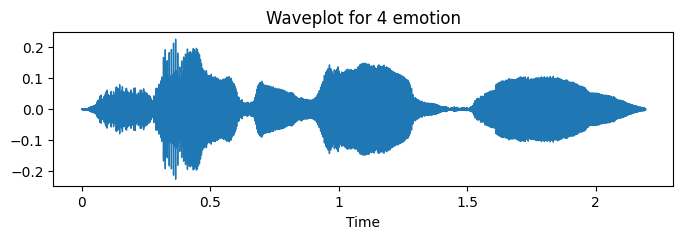

In [8]:
emotion_label = 4
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.file_path[df.Stress == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)



In [9]:
################### # Data Augmentation Functions Adding more variations to the training data(tech: time_stretch, pitch_shift, noise injection,)
def augment_audio(data, sr):
    # Randomly apply one or more augmentations
    if np.random.random() < 0.5:
        data = librosa.effects.time_stretch(data, rate=np.random.uniform(0.8, 1.2))  # Time Stretching: Stretch or compress the audio without altering the pitch.
    # if np.random.random() < 0.5:          # Pitch Shifting: Modify the pitch of the audio.
    #     n_steps = np.random.uniform(-5, 5)     # Randomly shift pitch between -5 and +5 semitones
    #     data = librosa.effects.pitch_shift(data, sr, n_steps)
    if np.random.random() < 0.5:
        noise = np.random.randn(len(data))    #Noise Injection: Add random noise to the audio.
        data = data + 0.005 * noise

    if np.random.random() < 0.5:   # Time Shifting: Shift the audio signal in time.
        shift = np.random.randint(-sr // 10, sr // 10)  # Shift by up to 0.1 seconds
        data = np.roll(data, shift)  # Roll the array elements
        if shift > 0:
            data[:shift] = 0   # # Zero out the empty indices if rolling exceeds length
        else:
            data[shift:] = 0
    return data

In [10]:
def extract_mfcc(filename, augment=False):
    y, sr = librosa.load(filename, duration=3, offset=0.5) # Load the audio file with a maximum duration of 3 seconds and an offset of 0.5 seconds.

    # If we want to apply audio augmentation (changing the audio slightly), do it here.
    if augment:
        y = augment_audio(y, sr)  # Call the augment_audio function to change the audio.

        # Check if the augmented audio data is a 1D array (like a single line of numbers).
        if y.ndim != 1:
            raise ValueError("Augmented audio data is not a 1D array.")  # Raise an error if the shape is wrong.

    # Extract the MFCC features from the audio. # MFCC (Mel-Frequency Cepstral Coefficients) are special features that help us understand the sound.
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)  # Calculate and average the MFCCs.

    return mfcc  # Return the MFCC features so we can use them later.

In [11]:
extract_mfcc(df['file_path'][0])

array([-4.7339130e+02,  4.7294632e+01,  2.8475006e+01,  1.2212405e+01,
        3.8459609e+00,  3.2751896e+00, -6.1293321e+00, -9.3895626e-01,
       -9.0621033e+00, -3.1559610e+00, -1.4134625e+01, -8.4121017e+00,
       -4.4867783e+00, -5.4387865e+00,  2.1482370e+00,  6.2989593e-01,
       -2.4769016e-01,  1.5187676e+01, -1.7599201e-01,  3.7210965e+00,
       -2.6232871e-01,  3.5814807e+00,  2.9146838e-01,  7.3344364e+00,
        1.1481957e+00,  9.5568810e+00,  2.5338573e+00,  8.5114403e+00,
       -2.0903741e-01,  3.6643207e+00,  1.4304154e+00,  4.1321154e+00,
        2.2391644e+00,  4.5913133e-01,  7.4096613e-02,  6.6158047e+00,
        5.4513044e+00,  6.6132550e+00,  6.6946807e+00,  1.0025414e+01],
      dtype=float32)

In [12]:
# Now we extract features from all the audio files in the 'speech' column of our DataFrame.
# We apply augmentation to some and keep the original audio for comparison.
X_mfcc_augmented = df['file_path'].apply(lambda x: extract_mfcc(x, augment=True))
X_mfcc_original = df['file_path'].apply(lambda x: extract_mfcc(x, augment=False))

In [13]:
X_mfcc_augmented.shape, X_mfcc_augmented.shape

((5600,), (5600,))

In [14]:
# Combine features
X_combined = pd.concat([X_mfcc_augmented, X_mfcc_original], axis=0)
X_data = np.array([x for x in X_combined])
X_data = np.expand_dims(X_data, -1)

In [15]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Encode the 'Stress' column
df['Stress'] = label_encoder.fit_transform(df['Stress'])

# Check the encoding
print(df['Stress'])
print(df['Stress'].unique())

0       1
1       1
2       1
3       1
4       1
       ..
5595    0
5596    0
5597    0
5598    0
5599    0
Name: Stress, Length: 5600, dtype: int64
[1 2 6 4 0 5 3]


In [16]:
y_data = np.asarray(df["Stress"])  # Original labels, shape (5600,)
y_data = np.expand_dims(y_data, axis=1)  # Reshape to (5600, 1)
y_data = np.concatenate([y_data, y_data])  # Duplicate along rows to match augmented data, shape (11200, 1

In [17]:
print("Feature shape:", X_data.shape)
print("Label shape:", y_data.shape)

Feature shape: (11200, 40, 1)
Label shape: (11200, 1)


In [18]:
!pip install opensmile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 27.6 MB/s eta 0:00:00


# traditional machine learning model

In [19]:
import opensmile
import librosa
import numpy as np
import pandas as pd
import os

# Function to apply augmentation
def augment_audio(data, sr):
    if np.random.random() < 0.5:
        data = librosa.effects.time_stretch(data, rate=np.random.uniform(0.8, 1.2))
    if np.random.random() < 0.5:
        noise = np.random.randn(len(data))
        data = data + 0.005 * noise
    if np.random.random() < 0.5:
        shift = np.random.randint(-sr // 10, sr // 10)
        data = np.roll(data, shift)
        if shift > 0:
            data[:shift] = 0
        else:
            data[shift:] = 0
    return data

# OpenSMILE feature extraction using the official opensmile package
def extract_opensmile_features(file_path, augment=False, output_dir="opensmile_features"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load audio
    y, sr = librosa.load(file_path, duration=3, offset=0.5)

    # Apply augmentation if needed
    if augment:
        y = augment_audio(y, sr)

    # Initialize OpenSMILE feature extraction
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,  # Choose a predefined feature set
        feature_level=opensmile.FeatureLevel.Functionals  # Extract functionals (e.g., mean, variance)
    )

    # Extract features (pass sampling rate `sr` as an argument)
    features = smile.process_signal(y, sr)

    # Save features to CSV
    output_file = os.path.join(output_dir, f"{os.path.basename(file_path)}.csv")
    features.to_csv(output_file)

    return output_file

# Extract features from all files with augmentation
X_opensmile_augmented = df['file_path'].apply(lambda x: extract_opensmile_features(x, augment=True))
X_opensmile_original = df['file_path'].apply(lambda x: extract_opensmile_features(x, augment=False))



# Continue with your train/test split and model training as usual


In [20]:

# Process features from OpenSMILE
features_augmented = []
for file_path in X_opensmile_augmented:
    feature_df = pd.read_csv(file_path)
    numerical_features = feature_df.select_dtypes(include=[np.number])  # Only select numerical features
    features_augmented.append(numerical_features.values.flatten())

features_original = []
for file_path in X_opensmile_original:
    feature_df = pd.read_csv(file_path)
    numerical_features = feature_df.select_dtypes(include=[np.number])  # Only select numerical features
    features_original.append(numerical_features.values.flatten())

# Combine augmented and original features
X_combined = np.array(features_augmented + features_original)

# Ensure feature dimensionality matches model requirements
X = np.expand_dims(X_combined, -1)
y = np.asarray(df["Stress"])
y = np.concatenate([y, y])  # Duplicates labels # Augmented data replicates labels

# Proceed with train/test splitting and model training


In [21]:
# print(len(X))
print(len(y))

11200


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

In [23]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (9856, 88, 1), y_train shape: (9856,)
X_val shape: (940, 88, 1), y_val shape: (940,)
X_test shape: (404, 88, 1), y_test shape: (404,)


In [24]:
# Reshape data
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (9856, 40)
X_val_flat = X_val.reshape(X_val.shape[0], -1)        # Shape: (940, 40)
X_test_flat = X_test.reshape(X_test.shape[0], -1)     # Shape: (404, 40)

In [25]:
y_train_flat = y_train.ravel()  # Flatten to shape (9856,)
y_val_flat = y_val.ravel()      # Flatten to shape (940,)
y_test_flat = y_test.ravel()    # Flatten to shape (404,)


In [26]:
print(X_train_flat.dtype)
print(y_train_flat.dtype)


float64
int64


In [27]:
print(X_train_flat[:5])  # Inspect a few rows of feature data
print(y_train_flat[:5])  # Inspect a few rows of target data


[[ 3.95878450e+01  1.91941890e-01  3.46615400e+01  3.62724040e+01
   4.55201720e+01  1.08586310e+01  6.10771520e+01  2.22213940e+01
   1.73881960e+02  1.32828520e+02  4.39829900e-01  7.47207940e-01
   1.28916130e-01  3.71984870e-01  7.03499140e-01  5.74583000e-01
   8.52613500e+00  8.14352500e+00  3.01210520e+00  2.66459850e+00
   2.32831270e-01  9.87859550e-01  1.40905100e+01  1.47132860e+00
   9.50291100e+00  1.69320260e+00  5.93235540e+00  2.95789800e+00
  -1.47616290e+01 -1.40300310e+00  3.83064800e-02  1.44199660e+00
   8.41066500e-01  7.82938000e-01  8.68431500e+00  3.30874000e-01
   1.02022295e+01  8.02265500e-01  1.54843370e+01  1.20802070e+00
   6.87251160e+02  5.14681600e-01  1.15964260e+03  2.63511570e-01
  -6.07477380e+01 -1.22775940e+00  1.72373560e+03  2.15512990e-01
   9.06722700e+02  5.16272800e-01 -5.36162720e+01 -1.16502620e+00
   2.76592190e+03  1.56505080e-01  6.73619450e+02  3.55191100e-01
  -5.15538200e+01 -1.23038160e+00 -1.33390665e+01 -8.14106170e-01
   2.42619

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train the SVC model
svc = SVC(kernel='linear', probability=True, random_state=1)  # Use 'probability=True' for ROC/AUC
svc.fit(X_train_flat, y_train_flat)

# Evaluate on validation data
svc_val_accuracy = svc.score(X_val_flat, y_val_flat)
print(f"SVC Validation Accuracy: {svc_val_accuracy:.2f}")


SVC Validation Accuracy: 0.98


In [29]:
import joblib
from google.colab import files
svc_filename = "svc_model_audio.pkl"
joblib.dump(svc, svc_filename)
print(f"Model saved to '{svc_filename}'")

# Download the model
files.download(svc_filename)

Model saved to 'svc_model_audio.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SVC Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        60
           2       0.96      0.93      0.95        59
           4       1.00      1.00      1.00        67
           5       0.93      0.96      0.94        52
           6       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        61
           9       1.00      1.00      1.00        55

    accuracy                           0.99       404
   macro avg       0.98      0.98      0.98       404
weighted avg       0.99      0.99      0.99       404



<Figure size 800x600 with 0 Axes>

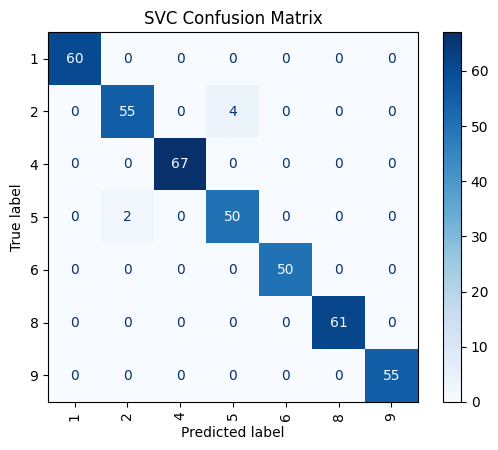

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred_svc = svc.predict(X_test_flat)
# Label mapping
label_mapping = {0: '1', 1: '2', 2: '4', 3: '5', 4: '6', 5: '8', 6: '9'}

# Decode true and predicted labels
y_test_decoded = [label_mapping[label] for label in y_test_flat]
y_pred_decoded = [label_mapping[label] for label in y_pred_svc]

# Classification report with label mapping
print("SVC Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

# Confusion matrix with label mapping
cm_svc = confusion_matrix(y_test_decoded, y_pred_decoded, labels=list(label_mapping.values()))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=list(label_mapping.values()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("SVC Confusion Matrix")
plt.show()


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train_flat, y_train_flat)

# Evaluate on validation data
rf_val_accuracy = rf.score(X_val_flat, y_val_flat)
print(f"Random Forest Validation Accuracy: {rf_val_accuracy:.2f}")


Random Forest Validation Accuracy: 1.00


In [32]:
import joblib
from google.colab import files
rf_filename = "rf_model_audio.pkl"
joblib.dump(rf, rf_filename)
print(f"Model saved to '{rf_filename}'")

# Download the model
files.download(rf_filename)

Model saved to 'rf_model_audio.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest Classification Report :
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        59
           4       1.00      1.00      1.00        67
           5       1.00      1.00      1.00        52
           6       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        61
           9       1.00      1.00      1.00        55

    accuracy                           1.00       404
   macro avg       1.00      1.00      1.00       404
weighted avg       1.00      1.00      1.00       404



<Figure size 800x600 with 0 Axes>

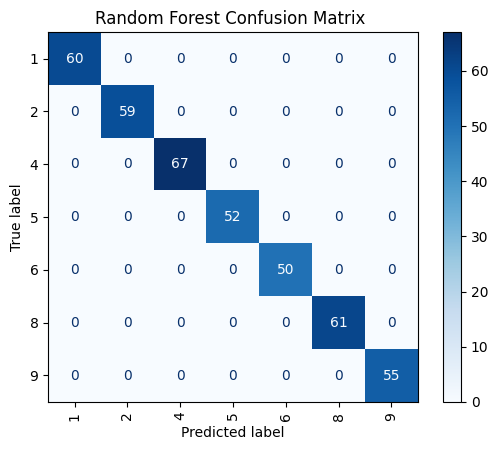

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred_rf = rf.predict(X_test_flat)
# Label mapping
label_mapping = {0: '1', 1: '2', 2: '4', 3: '5', 4: '6', 5: '8', 6: '9'}

# Decode true and predicted labels
y_test_decoded = [label_mapping[label] for label in y_test_flat]
y_pred_decoded = [label_mapping[label] for label in y_pred_rf]

# Classification report with label mapping
print("Random Forest Classification Report :")
print(classification_report(y_test_decoded, y_pred_decoded))

# Confusion matrix with label mapping
cm_rf = confusion_matrix(y_test_decoded, y_pred_decoded, labels=list(label_mapping.values()))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=list(label_mapping.values()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Random Forest Confusion Matrix ")
plt.show()


# CNN Model

In [34]:
print(len(X_data))
print(len(y_data))

11200
11200


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_to_split, y_train, y_to_split = train_test_split(X_data, y_data, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

In [36]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (9856, 40, 1), y_train shape: (9856, 1)
X_val shape: (940, 40, 1), y_val shape: (940, 1)
X_test shape: (404, 40, 1), y_test shape: (404, 1)


In [37]:
import torch

# Convert y_train to a tensor if it's a NumPy array
y_train_tensor = torch.tensor(y_train)

# Now you can use torch.unique
print(torch.unique(y_train_tensor))


tensor([0, 1, 2, 3, 4, 5, 6])


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class StressCNN(nn.Module):
    def __init__(self, num_classes=7):  # Changed from 7 to 9
        super(StressCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.relu = nn.ReLU()

        # Adjusted size after convolution and pooling
        self.fc1 = nn.Linear(64 * 10, 128)  # Input size is now 640, after flattening
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 640)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Adjust the labels by subtracting 1 from each target value
y_train_adjusted = y_train
y_val_adjusted = y_val
y_test_adjusted = y_test


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)  # (batch_size, 1, 40)
y_train_tensor = torch.tensor(y_train_adjusted, dtype=torch.long).squeeze()  # (batch_size,)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 2, 1)
y_val_tensor = torch.tensor(y_val_adjusted, dtype=torch.long).squeeze()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_test_tensor = torch.tensor(y_test_adjusted, dtype=torch.long).squeeze()

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

print(torch.unique(y_train_tensor))  # Check unique labels in the training set
print(torch.unique(y_val_tensor))    # Check unique labels in the validation set



tensor([0, 1, 2, 3, 4, 5, 6])
tensor([0, 1, 2, 3, 4, 5, 6])


In [40]:
# Check the shape of your training and validation data
print(X_train_tensor.shape)  # Should be (batch_size, seq_len, input_dim)
print(X_val_tensor.shape)    # Should be (batch_size, seq_len, input_dim)

torch.Size([9856, 1, 40])
torch.Size([940, 1, 40])


In [41]:
# Initialize the model
num_classes = 7  # Adjust based on your dataset
model = StressCNN(num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [42]:
# Track history
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# Early stopping parameters
early_stop_patience = 10  # Number of epochs to wait for improvement in validation loss
best_val_loss = float('inf')
patience_counter = 0

# Training loop with validation and early stopping
for epoch in range(500):  # Train for up to 500 epochs or until early stopping
    model.train()  # Set the model to training mode
    optimizer.zero_grad()

    # Forward pass on training data
    outputs = model(X_train_tensor)  # Replace X_train_tensor with your training data tensor
    loss = criterion(outputs, y_train_tensor)  # Replace y_train_tensor with your training labels
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_train_tensor).sum().item()
    train_accuracy = correct / y_train_tensor.size(0) * 100

    # Validation step
    model.eval()  # Set the model to evaluation mode for validation
    with torch.no_grad():
        val_outputs = model(X_val_tensor)  # Replace X_val_tensor with your validation data tensor
        val_loss = criterion(val_outputs, y_val_tensor)  # Replace y_val_tensor with your validation labels
        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = (val_predicted == y_val_tensor).sum().item()
        val_accuracy = val_correct / y_val_tensor.size(0) * 100

    # Store history
    history["train_loss"].append(loss.item())
    history["val_loss"].append(val_loss.item())
    history["train_acc"].append(train_accuracy)
    history["val_acc"].append(val_accuracy)

    # Print progress
    print(f"Epoch [{epoch+1}/500], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping check based on validation loss
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0  # Reset counter if improvement
    else:
        patience_counter += 1

    # Trigger early stopping if validation loss doesn't improve
    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
        break


Epoch [1/500], Train Loss: 4.2569, Train Accuracy: 13.50%
Validation Loss: 2.0387, Validation Accuracy: 26.28%
Epoch [2/500], Train Loss: 3.1695, Train Accuracy: 18.03%
Validation Loss: 1.7277, Validation Accuracy: 36.28%
Epoch [3/500], Train Loss: 2.5545, Train Accuracy: 23.29%
Validation Loss: 1.4532, Validation Accuracy: 45.74%
Epoch [4/500], Train Loss: 1.9945, Train Accuracy: 30.16%
Validation Loss: 1.2588, Validation Accuracy: 59.57%
Epoch [5/500], Train Loss: 1.6136, Train Accuracy: 40.29%
Validation Loss: 1.1529, Validation Accuracy: 69.57%
Epoch [6/500], Train Loss: 1.4075, Train Accuracy: 48.19%
Validation Loss: 1.1439, Validation Accuracy: 64.26%
Epoch [7/500], Train Loss: 1.3162, Train Accuracy: 53.27%
Validation Loss: 1.1340, Validation Accuracy: 63.62%
Epoch [8/500], Train Loss: 1.2659, Train Accuracy: 55.72%
Validation Loss: 1.0753, Validation Accuracy: 64.79%
Epoch [9/500], Train Loss: 1.1838, Train Accuracy: 59.49%
Validation Loss: 1.0020, Validation Accuracy: 67.45%
E

In [43]:
torch.save(model.state_dict(), "trained_model_cnn_audio.pth")
print("Model saved to 'trained_model.pth'")
from google.colab import files
files.download("trained_model_cnn_audio.pth")

Model saved to 'trained_model.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

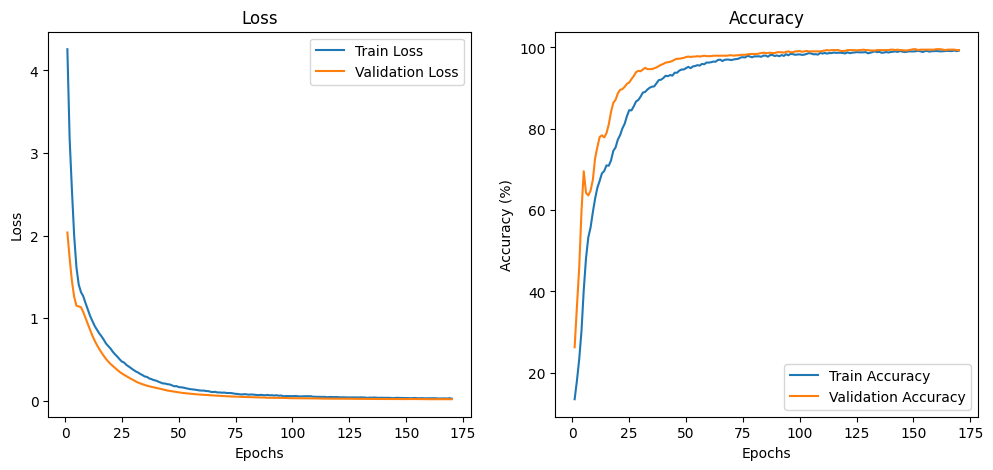


Classification Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       129
           2       1.00      0.98      0.99       131
           4       0.98      0.99      0.99       126
           5       0.99      0.99      0.99       134
           6       0.98      0.98      0.98       132
           8       1.00      1.00      1.00       149
           9       1.00      1.00      1.00       139

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940



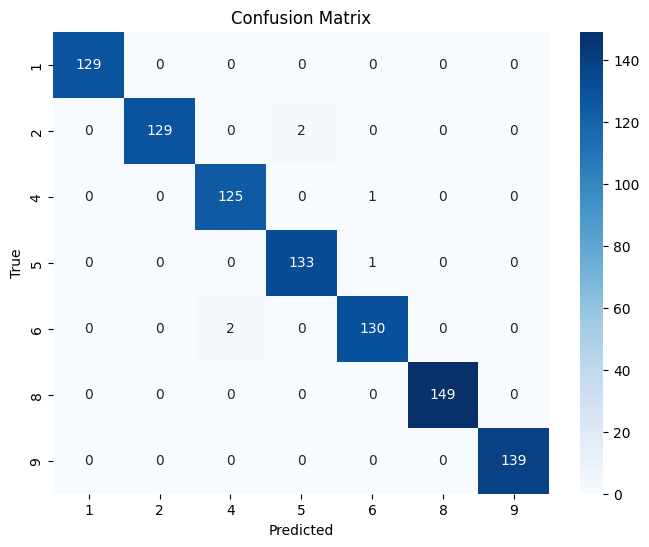

ROC curve and AUC are only applicable for binary classification.


In [44]:

# Plot loss and accuracy curves
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

plot_history(history)

# Classification report
val_pred = val_predicted.cpu().numpy()
val_true = y_val_tensor.cpu().numpy()
# Label mapping

label_mapping = {0: '1', 1: '2', 2: '4', 3: '5', 4: '6', 5: '8', 6: '9'}

# Decode labels
val_true_decoded = [label_mapping[label] for label in val_true]
val_pred_decoded = [label_mapping[label] for label in val_pred]

# Classification report with mapped labels
print("\nClassification Report")
print(classification_report(val_true_decoded, val_pred_decoded, target_names=list(label_mapping.values())))

# Confusion matrix with mapped labels
cm = confusion_matrix(val_true_decoded, val_pred_decoded, labels=list(label_mapping.values()))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC and AUC
if len(set(val_true)) == 2:  # Binary classification
    val_probs = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
    auc = roc_auc_score(val_true, val_probs)
    fpr, tpr, _ = roc_curve(val_true, val_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
else:
    print("ROC curve and AUC are only applicable for binary classification.")

# LSTM+ CNN

In [45]:
# Define the model
class LSTM_CNN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers, cnn_channels, num_classes):
        super(LSTM_CNN_Model, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.conv1 = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(cnn_channels, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [46]:
# Check the shape of your training and validation data
print(X_train_tensor.shape)  # Should be (batch_size, seq_len, input_dim)
print(X_val_tensor.shape)    # Should be (batch_size, seq_len, input_dim)


torch.Size([9856, 1, 40])
torch.Size([940, 1, 40])


In [47]:
# Initialize model, criterion, and optimizer
model = LSTM_CNN_Model(input_dim=40, hidden_dim=64, lstm_layers=2, cnn_channels=32, num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track history
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# Early stopping parameters
early_stop_patience = 10
best_val_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_train_tensor).sum().item()
    train_accuracy = correct / y_train_tensor.size(0) * 100

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = (val_predicted == y_val_tensor).sum().item()
        val_accuracy = val_correct / y_val_tensor.size(0) * 100

    # Store history
    history["train_loss"].append(loss.item())
    history["val_loss"].append(val_loss.item())
    history["train_acc"].append(train_accuracy)
    history["val_acc"].append(val_accuracy)

    # Verbose output
    print(f"Epoch [{epoch+1}/500], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
        break



Epoch [1/500], Train Loss: 1.9494, Train Accuracy: 14.27%
Validation Loss: 1.9461, Validation Accuracy: 14.79%
Epoch [2/500], Train Loss: 1.9486, Train Accuracy: 14.27%
Validation Loss: 1.9452, Validation Accuracy: 14.79%
Epoch [3/500], Train Loss: 1.9470, Train Accuracy: 14.28%
Validation Loss: 1.9442, Validation Accuracy: 14.79%
Epoch [4/500], Train Loss: 1.9457, Train Accuracy: 14.29%
Validation Loss: 1.9432, Validation Accuracy: 14.79%
Epoch [5/500], Train Loss: 1.9442, Train Accuracy: 14.28%
Validation Loss: 1.9420, Validation Accuracy: 14.79%
Epoch [6/500], Train Loss: 1.9437, Train Accuracy: 14.43%
Validation Loss: 1.9406, Validation Accuracy: 14.79%
Epoch [7/500], Train Loss: 1.9416, Train Accuracy: 14.49%
Validation Loss: 1.9390, Validation Accuracy: 14.79%
Epoch [8/500], Train Loss: 1.9400, Train Accuracy: 14.71%
Validation Loss: 1.9372, Validation Accuracy: 14.79%
Epoch [9/500], Train Loss: 1.9386, Train Accuracy: 15.46%
Validation Loss: 1.9351, Validation Accuracy: 14.79%
E

In [50]:
torch.save(model.state_dict(), "trained_model_cnn_lstm.pth")
print("Model saved to 'trained_model.pth'")
from google.colab import files
files.download("trained_model_cnn_lstm.pth")

Model saved to 'trained_model.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

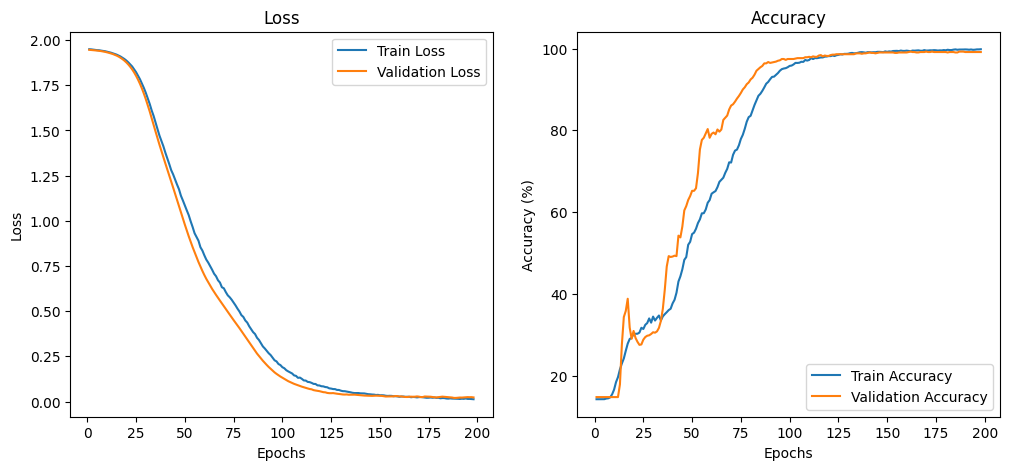


Classification Report :

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       129
           2       1.00      0.97      0.98       131
           4       0.98      1.00      0.99       126
           5       0.96      1.00      0.98       134
           6       1.00      0.97      0.98       132
           8       1.00      1.00      1.00       149
           9       1.00      1.00      1.00       139

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940



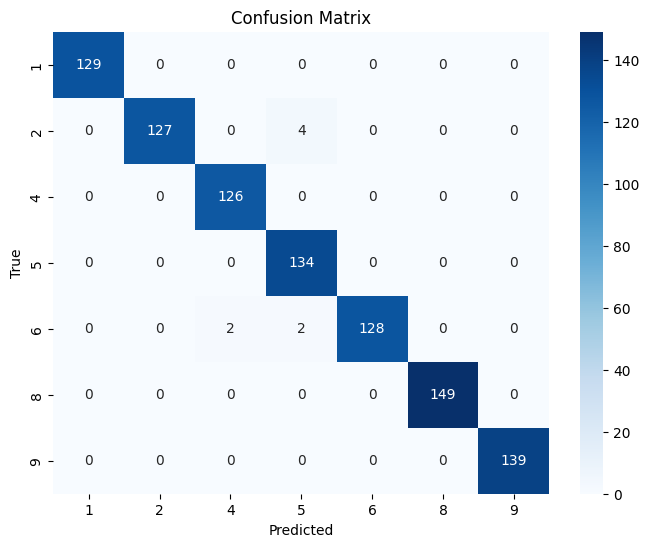

ROC curve and AUC are only applicable for binary classification.


In [51]:

# Plot loss and accuracy curves
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

plot_history(history)

# Classification report
val_pred = val_predicted.cpu().numpy()
val_true = y_val_tensor.cpu().numpy()

# Label mapping
label_mapping = {0: '1', 1: '2', 2: '4', 3: '5', 4: '6', 5: '8', 6: '9'}

# Decode labels
val_true_decoded = [label_mapping[label] for label in val_true]
val_pred_decoded = [label_mapping[label] for label in val_pred]

# Classification report with mapped labels
print("\nClassification Report :\n")
print(classification_report(val_true_decoded, val_pred_decoded, target_names=list(label_mapping.values())))

# Confusion matrix with mapped labels
cm = confusion_matrix(val_true_decoded, val_pred_decoded, labels=list(label_mapping.values()))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC and AUC
if len(set(val_true)) == 2:  # Binary classification
    val_probs = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
    auc = roc_auc_score(val_true, val_probs)
    fpr, tpr, _ = roc_curve(val_true, val_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
else:
    print("ROC curve and AUC are only applicable for binary classification.")


stress cnn model

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the model class
class AudioStressCNN(nn.Module):
    def __init__(self, num_classes=7):  # Number of output classes
        super(AudioStressCNN, self).__init__()

        # 1D CNN Layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.batch_norm3 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool1d(kernel_size=2)

        # Dropout layer for CNN feature extraction
        self.dropout_cnn = nn.Dropout(0.2)

        # LSTM Layer for capturing temporal dependencies
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(128 * 2, 256)  # Bidirectional LSTM doubles the hidden size
        self.dropout_fc = nn.Dropout(0.5)  # Dropout after FC1
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # CNN feature extraction
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout_cnn(x)

        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_cnn(x)

        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout_cnn(x)

        # Transpose for LSTM
        x = x.permute(0, 2, 1)

        # LSTM for temporal modeling
        x, _ = self.lstm(x)

        # Take the last time step's output
        x = x[:, -1, :]

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

from sklearn.model_selection import KFold
import numpy as np

# Number of folds
k_folds = 5

# Initialize k-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Track overall history
overall_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# Convert dataset to numpy for k-fold compatibility
X_data = X_train_tensor.numpy()
y_data = y_train_tensor.numpy()

# Iterate through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Split the data into train and validation sets for this fold
    X_train_fold = torch.tensor(X_data[train_idx], dtype=torch.float32)
    y_train_fold = torch.tensor(y_data[train_idx], dtype=torch.long)
    X_val_fold = torch.tensor(X_data[val_idx], dtype=torch.float32)
    y_val_fold = torch.tensor(y_data[val_idx], dtype=torch.long)

    # Create DataLoaders for the fold
    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size)

    # Initialize the model, loss function, and optimizer for this fold
    model = AudioStressCNN(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Track history for this fold
    fold_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0

    # Training loop with validation for the current fold
    for epoch in range(500):  # Train for up to 500 epochs or until early stopping
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_loss = running_loss / total_train
        train_accuracy = correct_train / total_train * 100

        # Validation step
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                val_outputs = model(X_batch)
                val_loss = criterion(val_outputs, y_batch)
                running_val_loss += val_loss.item() * X_batch.size(0)
                _, predicted = torch.max(val_outputs, 1)
                correct_val += (predicted == y_batch).sum().item()
                total_val += y_batch.size(0)

        val_loss = running_val_loss / total_val
        val_accuracy = correct_val / total_val * 100

        # Store history for this fold
        fold_history["train_loss"].append(train_loss)
        fold_history["val_loss"].append(val_loss)
        fold_history["train_acc"].append(train_accuracy)
        fold_history["val_acc"].append(val_accuracy)

        # Print progress
        print(f"Epoch [{epoch+1}/500], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if improvement
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

    # Append fold history to overall history
    overall_history["train_loss"].append(fold_history["train_loss"])
    overall_history["val_loss"].append(fold_history["val_loss"])
    overall_history["train_acc"].append(fold_history["train_acc"])
    overall_history["val_acc"].append(fold_history["val_acc"])

    print(f"Fold {fold + 1} completed. Best Validation Loss: {best_val_loss:.4f}\n")

# Average metrics across all folds
print("K-Fold Cross Validation Results:")
print(f"Average Training Loss: {np.mean([np.mean(f) for f in overall_history['train_loss']]):.4f}")
print(f"Average Validation Loss: {np.mean([np.mean(f) for f in overall_history['val_loss']]):.4f}")
print(f"Average Training Accuracy: {np.mean([np.mean(f) for f in overall_history['train_acc']]):.2f}%")
print(f"Average Validation Accuracy: {np.mean([np.mean(f) for f in overall_history['val_acc']]):.2f}%")



Fold 1/5
Epoch [1/500], Train Loss: 0.7060, Train Accuracy: 72.70%
Validation Loss: 0.1436, Validation Accuracy: 95.03%
Epoch [2/500], Train Loss: 0.2076, Train Accuracy: 93.14%
Validation Loss: 0.0921, Validation Accuracy: 96.86%
Epoch [3/500], Train Loss: 0.1334, Train Accuracy: 95.52%
Validation Loss: 0.0515, Validation Accuracy: 98.17%
Epoch [4/500], Train Loss: 0.1171, Train Accuracy: 96.09%
Validation Loss: 0.0604, Validation Accuracy: 97.41%
Epoch [5/500], Train Loss: 0.1068, Train Accuracy: 96.41%
Validation Loss: 0.0560, Validation Accuracy: 98.17%
Epoch [6/500], Train Loss: 0.0751, Train Accuracy: 97.43%
Validation Loss: 0.0391, Validation Accuracy: 98.63%
Epoch [7/500], Train Loss: 0.0660, Train Accuracy: 97.77%
Validation Loss: 0.0617, Validation Accuracy: 97.97%
Epoch [8/500], Train Loss: 0.0679, Train Accuracy: 97.69%
Validation Loss: 0.0664, Validation Accuracy: 97.72%
Epoch [9/500], Train Loss: 0.0687, Train Accuracy: 97.84%
Validation Loss: 0.0387, Validation Accuracy:

In [53]:
torch.save(model.state_dict(), "trained_model_modify_cnn_lstm_audio.pth")
print("Model saved to 'trained_model.pth'")
from google.colab import files
files.download("trained_model_modify_cnn_lstm_audio.pth")

Model saved to 'trained_model.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

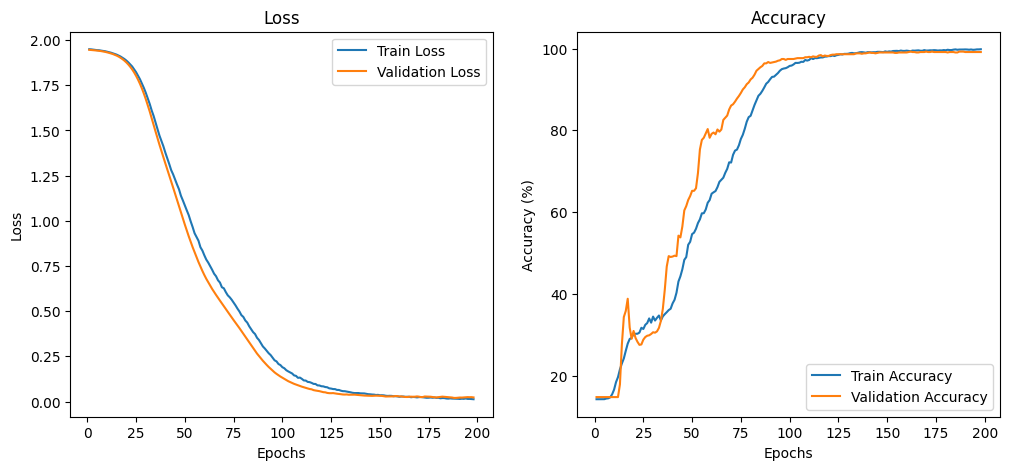


Classification Report :

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       129
           2       1.00      0.97      0.98       131
           4       0.98      1.00      0.99       126
           5       0.96      1.00      0.98       134
           6       1.00      0.97      0.98       132
           8       1.00      1.00      1.00       149
           9       1.00      1.00      1.00       139

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940



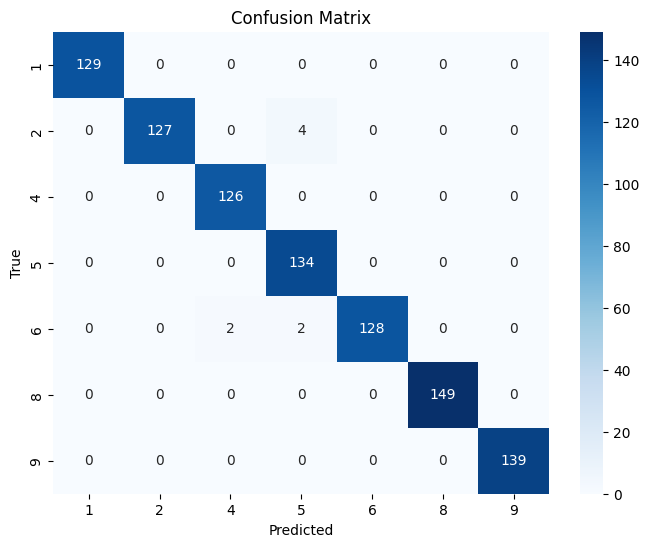

ROC curve and AUC are only applicable for binary classification.


In [54]:

# Plot loss and accuracy curves
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

plot_history(history)

# Classification report
val_pred = val_predicted.cpu().numpy()
val_true = y_val_tensor.cpu().numpy()

# Label mapping
label_mapping = {0: '1', 1: '2', 2: '4', 3: '5', 4: '6', 5: '8', 6: '9'}

# Decode labels
val_true_decoded = [label_mapping[label] for label in val_true]
val_pred_decoded = [label_mapping[label] for label in val_pred]

# Classification report with mapped labels
print("\nClassification Report :\n")
print(classification_report(val_true_decoded, val_pred_decoded, target_names=list(label_mapping.values())))

# Confusion matrix with mapped labels
cm = confusion_matrix(val_true_decoded, val_pred_decoded, labels=list(label_mapping.values()))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC and AUC
if len(set(val_true)) == 2:  # Binary classification
    val_probs = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
    auc = roc_auc_score(val_true, val_probs)
    fpr, tpr, _ = roc_curve(val_true, val_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
else:
    print("ROC curve and AUC are only applicable for binary classification.")
